In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip /content/drive/MyDrive/dogs-vs-cats.zip

In [ ]:
# Reproducability
seed_value = 10

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [ ]:
# Necessary imports
import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use("ggplot")
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# unzip folders
!unzip /content/train.zip
!unzip /content/test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [ ]:
from glob import glob

file_names = glob('./train/*.jpg')
categories = [1 if 'dog' in pic else 0 for pic in os.listdir("./train")]

df = pd.DataFrame({'filename': file_names, 'category':categories})
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("shape:", df.shape)
df.head()

shape: (25000, 2)


,filename,category
0,./train/dog.8129.jpg,dog
1,./train/dog.3724.jpg,dog
2,./train/cat.9592.jpg,cat
3,./train/dog.8782.jpg,dog
4,./train/cat.11114.jpg,cat


In [ ]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, test_size=0.2, random_state=10)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

# print shape
train_df.shape, validate_df.shape

((20000, 2), (5000, 2))

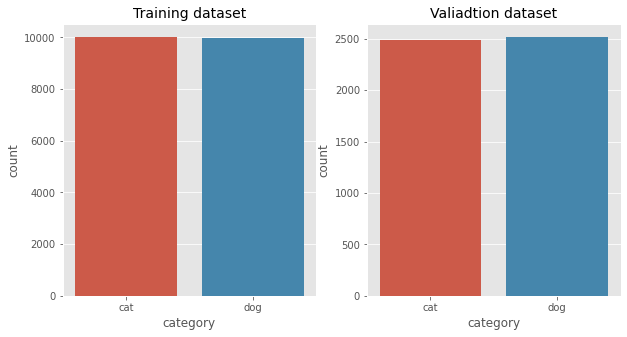

In [ ]:
# plot label counts
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.countplot(train_df.category, ax=ax[0])
ax[0].set_title('Training dataset', fontsize=14)

sns.countplot(validate_df.category, ax=ax[1])
ax[1].set_title('Valiadtion dataset', fontsize=14);

In [ ]:
file_names = os.listdir("./test1")

test_df = pd.DataFrame({'filename': file_names})

print("shape:", test_df.shape)
test_df.head()

shape: (12500, 1)


,filename
0,5486.jpg
1,10210.jpg
2,5973.jpg
3,3632.jpg
4,3167.jpg


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (190,190)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale = 1/255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
#     directory='./Images/train', 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=validate_df,
#     directory='./Images/train',
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./test1",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


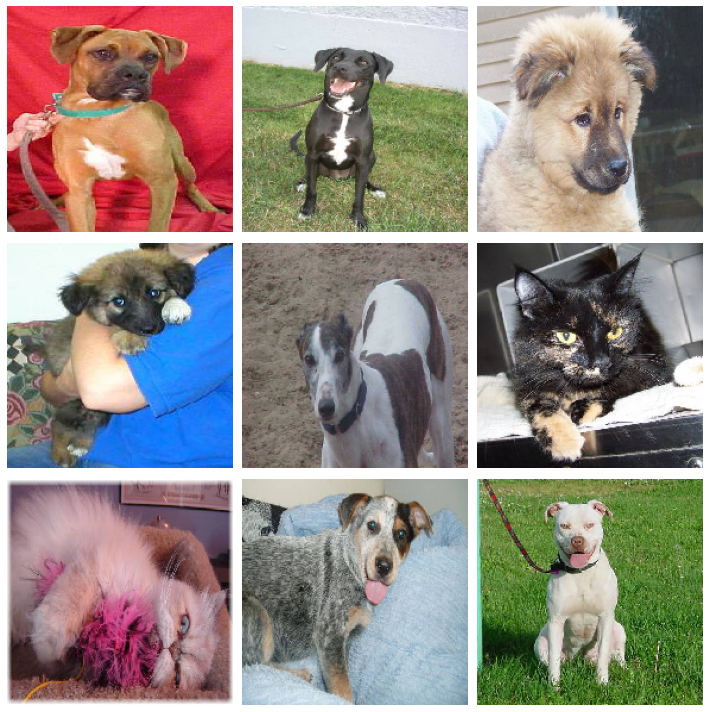

In [ ]:
# get a batch of 32 training images 
images = train_generator.next()[:9]

# plot 9 original training images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[0][i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

# read the pretrained VGG19
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(190, 190, 3))

vgg.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 190, 190, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 190, 190, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 190, 190, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 95, 95, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 95, 95, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 95, 95, 128)       147584    
                                                              

In [ ]:
# # Freezing all layers
# vgg.trainable = False

# print("This is the number of trainable weights of the VGG:", len(vgg.trainable_weights))

This is the number of trainable weights of the VGG: 0


In [ ]:
# Freezing all layers until the last 5 layers (block_5 layers)
vgg.trainable = True
for layer in vgg.layers[:-5]:
    layer.trainable = False
    
print("This is the number of trainable weights of the VGG:", len(vgg.trainable_weights))

This is the number of trainable weights of the VGG: 8


In [ ]:
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# # Create model using VGG
# x = vgg.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.3)(x)
# outputs = Dense(1, activation='sigmoid')(x)
# model_3 = Model(vgg.input, outputs)

# # Compile model
# model_3.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])

# # Fit model
# model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 190, 190, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 190, 190, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 190, 190, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 95, 95, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 95, 95, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 95, 95, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 47, 47, 128)       0   

In [ ]:
from tensorflow.keras.optimizers import SGD, Adadelta   # let's try different optimizer

# Create model using VGG
x = vgg.output
x = Flatten()(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)
model_4 = Model(vgg.input, outputs)

# Compile model
model_4.compile(loss="binary_crossentropy", metrics=["accuracy"],
                optimizer=SGD(lr=0.001))

# Fit model
model_4.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 190, 190, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 190, 190, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 190, 190, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 95, 95, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 95, 95, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 95, 95, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 47, 47, 128)       0   

In [ ]:
# # callbacks is a reguralization technique to brevent over fitting
# callbacks = [
#     EarlyStopping(patience=10),
#     ModelCheckpoint(filepath='./Models/model_3.keras', save_best_only=True, monitor='val_loss')
# ]

# # train the model
# history_3 = model_3.fit(train_generator, validation_data=valid_generator, epochs=40, callbacks=[callbacks])

Epoch 1/80
625/625 [==============================] - 133s 212ms/step - loss: 0.0926 - accuracy: 0.9862 - val_loss: 0.0980 - val_accuracy: 0.9662
Epoch 2/80
625/625 [==============================] - 105s 168ms/step - loss: 0.0507 - accuracy: 0.9893 - val_loss: 0.0900 - val_accuracy: 0.9664
Epoch 3/80
625/625 [==============================] - 105s 168ms/step - loss: 0.0402 - accuracy: 0.9894 - val_loss: 0.0897 - val_accuracy: 0.9662
Epoch 4/80
625/625 [==============================] - 105s 168ms/step - loss: 0.0341 - accuracy: 0.9906 - val_loss: 0.0896 - val_accuracy: 0.9660
Epoch 5/80
625/625 [==============================] - 105s 168ms/step - loss: 0.0314 - accuracy: 0.9897 - val_loss: 0.0895 - val_accuracy: 0.9656
Epoch 6/80
625/625 [==============================] - 105s 167ms/step - loss: 0.0289 - accuracy: 0.9908 - val_loss: 0.0911 - val_accuracy: 0.9658
Epoch 7/80
625/625 [==============================] - 106s 169ms/step - loss: 0.0276 - accuracy: 0.9906 - val_loss: 0.0942 -

In [ ]:
# callbacks is a reguralization technique to brevent over fitting
callbacks = [
    EarlyStopping(patience=4),
    ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001),
    ModelCheckpoint(filepath='./Models/model_4.keras', save_best_only=True, monitor='val_loss')
]

# train the model
history_4 = model_4.fit(train_generator, validation_data=valid_generator, epochs=40, callbacks=[callbacks])

Epoch 1/40
625/625 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9935

625/625 [==============================] - 116s 185ms/step - loss: 0.0218 - accuracy: 0.9935 - val_loss: 0.1078 - val_accuracy: 0.9666 - lr: 0.0100
Epoch 2/40
625/625 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9800

625/625 [==============================] - 114s 182ms/step - loss: 0.0549 - accuracy: 0.9800 - val_loss: 0.1485 - val_accuracy: 0.9386 - lr: 0.0100
Epoch 3/40
625/625 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9898

625/625 [==============================] - 112s 179ms/step - loss: 0.0303 - accuracy: 0.9898 - val_loss: 0.1089 - val_accuracy: 0.9610 - lr: 0.0100
Epoch 4/40
625/625 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9990

625/625 [==============================] - 113s 181ms/step - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.1275 - val_accuracy: 0.9654 - lr: 0.0100
Epoch 5/40
625/625 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9997

625/625 [==============================] - 113s 181ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0.1475 - val_accuracy: 0.9654 - lr: 0.0100


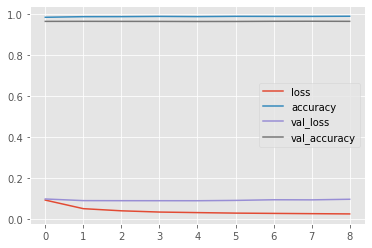

In [ ]:
# # plot model performance
# pd.DataFrame(history_3.history).plot();

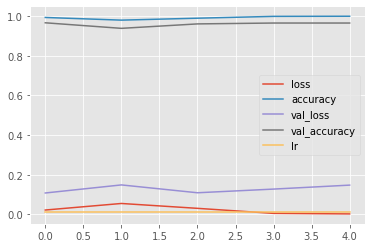

In [ ]:
# plot model performance
pd.DataFrame(history_4.history).plot();


In [ ]:
y_pred = model_4.predict(test_generator)
y_pred

391/391 [==============================] - 53s 135ms/step


array([[1.0000000e+00],
       [1.0592121e-08],
       [7.7276445e-07],
       ...,
       [1.5550246e-09],
       [1.6896789e-14],
       [1.0000000e+00]], dtype=float32)

In [ ]:

pd.DataFrame(y_pred).to_csv('sample.csv')   

In [ ]:
predicted_class_indices=np.round(y_pred)
pd.DataFrame(predicted_class_indices).to_csv('predicted_class_indices.csv') 
print(predicted_class_indices) 

[[1.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]


In [ ]:
labels = (train_generator.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
print(labels)
new_keys = [int(key[0]) for key in predicted_class_indices]
predictions = [labels[k] for k in new_keys]
print(predictions)

{'cat': 0, 'dog': 1}
{0: 'cat', 1: 'dog'}
['dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat'

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

In [ ]:
y_pred = model_4.predict(test_generator)
y_pred

391/391 [==============================] - 52s 134ms/step


array([[2.1785747e-16],
       [1.0000000e+00],
       [9.7374684e-01],
       ...,
       [9.3059140e-01],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (190, 190, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/content/test1/1.jpg')
pred = model_4.predict(image)
num_pred = np.round(pred)
num_pred =int(num_pred[0])


1/1 [==============================] - 0s 31ms/step


In [ ]:
import numpy as np

def dot_product(a, b):
    return np.dot(a, b)

a = np.array([1, 2, 3])
b = np.array([4, 5, 6])

print("Dot product of a and b:", dot_product(a, b))


Dot product of a and b: 32
